In [1]:
import numpy as np
import xarray as xr
import pandas as pd


import scipy.stats as stats
import cartopy as cart

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from tqdm import tqdm
import sys

from importlib import reload
sys.path.append('/nethome/4302001/NASTMW_DIC/tools')
import preprocess_timeseries
import event_identification

%config InlineBackend.figure_format = 'retina'

In [2]:
data_dir = "/storage/shared/oceanparcels/output_data/data_Daan/EDW_trajectories_postprocessed/"
ds = xr.open_dataset(data_dir + "EDW_wfluxes_B_2000-09-01_1095d_dt90_odt24.nc").isel(obs=slice(0, 366))
odt_days = int(np.diff(ds.isel(trajectory=0).time.data)[0]) / 1e9 / 60 / 60 / 24

In [3]:
yeardict = {year : {"ds" : xr.open_dataset(data_dir + f"EDW_wfluxes_B_{year}-09-01_1095d_dt90_odt24.nc").isel(obs=slice(0, 366))} for year in range(1995, 2016)}

In [4]:
mesh_z = xr.open_dataset("~/local_data/mesh/mesh_zgr_PSY4V2_deg_NA_subset.nc")
toplayer_bound = mesh_z.gdepw_1d.data[1]

In [5]:
# we select 10 random trajectories for illustration
np.random.seed(42)
rantraj = np.sort(np.random.choice(np.arange(0, ds.dims['trajectory']), 10, replace=False))
colors = plt.cm.tab10(np.linspace(0, 1, 10))


In [7]:
def plot_trajectories(ds, rantraj, obsslice=slice(None, None)):
    fig = plt.figure(figsize=(5, 6))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212, projection=cart.crs.PlateCarree())
    for i, traj in enumerate(rantraj):
        ax1.scatter(ds.lat.isel(trajectory=traj, obs=obsslice), -ds.z.isel(trajectory=traj, obs=obsslice), s=2, color=colors[i])
        ax1.plot(ds.lat.isel(trajectory=traj, obs=obsslice), -ds.z.isel(trajectory=traj, obs=obsslice), linewidth=0.5, color=colors[i])
        ax1.set_xlabel("Latitude (deg)")
        ax1.set_ylabel("Depth (m)")


        map = ax2.scatter(ds.lon.isel(trajectory=traj, obs=obsslice), ds.lat.isel(trajectory=traj, obs=obsslice), s=2, color=colors[i], transform=cart.crs.PlateCarree(), label=f"Trajectory {traj}")
        ax2.plot(ds.lon.isel(trajectory=traj, obs=obsslice), ds.lat.isel(trajectory=traj, obs=obsslice), linewidth=0.5, color=colors[i], transform=cart.crs.PlateCarree())

        ax2.coastlines()
        ax2.gridlines(draw_labels=['left', 'bottom'], linestyle='--', linewidth=0.5, zorder=0)

    # get the handles and labels for the first axes
    ax2.legend(loc='upper center', ncols=2, bbox_to_anchor=(0.5, -0.2))
    fig.tight_layout()



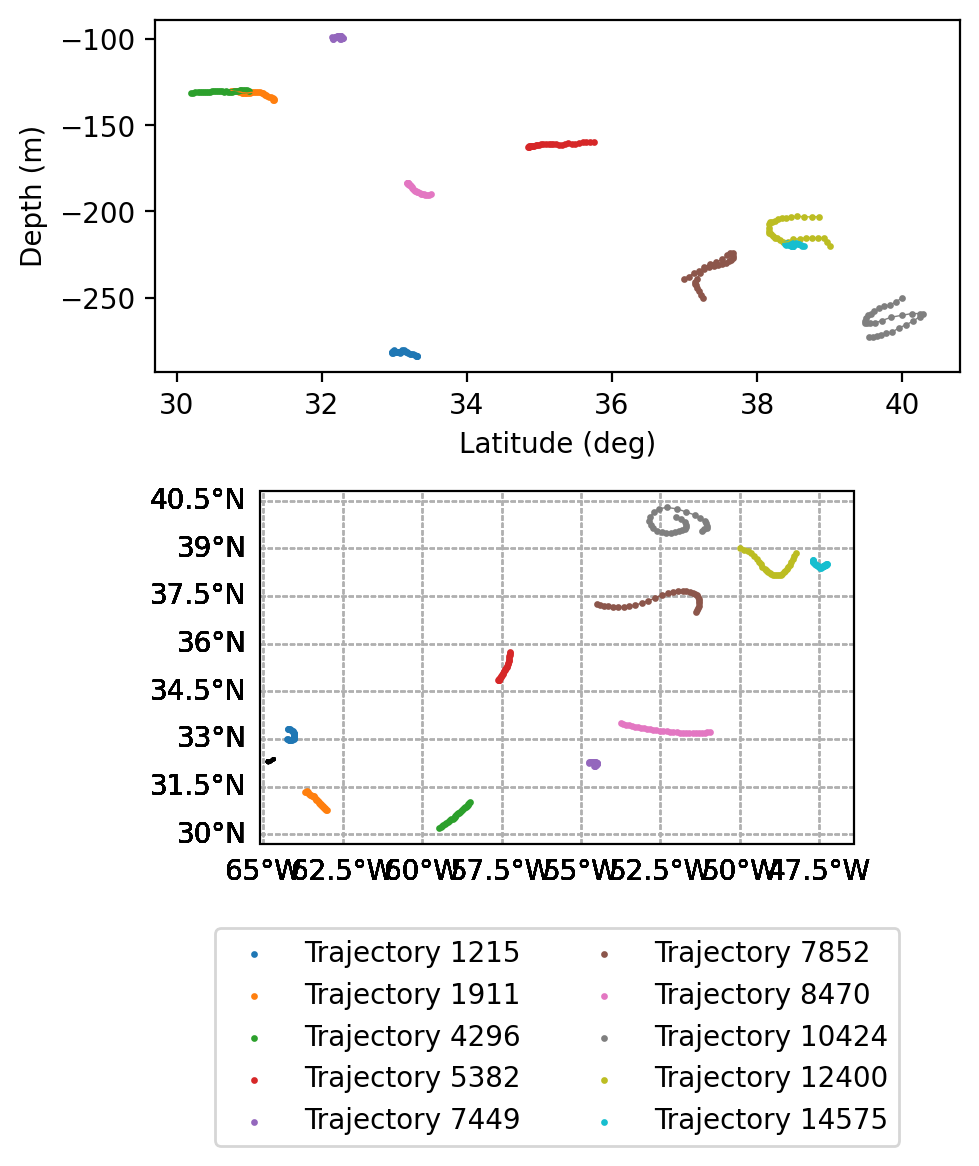

In [8]:
plot_trajectories(ds, rantraj, obsslice=slice(None, 30))

In [9]:
def plot_flux_attribution(ds, obsslice=slice(None, 30)):
    ds_sub = ds.isel(obs=obsslice)
    fig, axs = plt.subplots(3, 3, figsize=(8, 7))
    for i, traj in enumerate(rantraj[:9]):
        ax = axs.flatten()[i]
        ax.plot(np.arange(0, ds_sub['DDIC'].shape[1] * odt_days, odt_days), ds_sub['DDIC'][traj], label="total")
        ax.plot(np.arange(0, ds_sub['DDIC'].shape[1] * odt_days, odt_days), ds_sub['DDIC_bio_soft'][traj], label="soft-tissue")
        ax.plot(np.arange(0, ds_sub['DDIC'].shape[1] * odt_days, odt_days), ds_sub['DDIC_bio_carbonate'][traj], label="carbonate")
        ax.plot(np.arange(0, ds_sub['DDIC'].shape[1] * odt_days, odt_days), ds_sub['DDIC_diff'][traj], label="Mixing")
        ax.plot(np.arange(0, ds_sub['DDIC'].shape[1] * odt_days, odt_days), ds_sub['DDIC_residual'][traj], label="residual")
        
        ax.set_title(f"Traj. {traj} — avg depth = {ds_sub.z[traj].mean().values:.0f} m", color=colors[i], fontsize=10)
        # divide the values on the x-axis by 2
        ax.set_xlabel("Time (days)")
        if i%3 == 0:
            ax.set_ylabel(r"Flux (mmol m$^{-3}$ / $\Delta$ t)")
        ax.axhline(0, color="k", linestyle="--", zorder=0)

    fig.legend(*ax.get_legend_handles_labels(), loc="lower center", ncol=5)
    fig.suptitle(rf"DIC fluxes and their attribution ($\Delta$ t = {odt_days} day))")
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) 

/tmp/ipykernel_23103/3640122613.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])


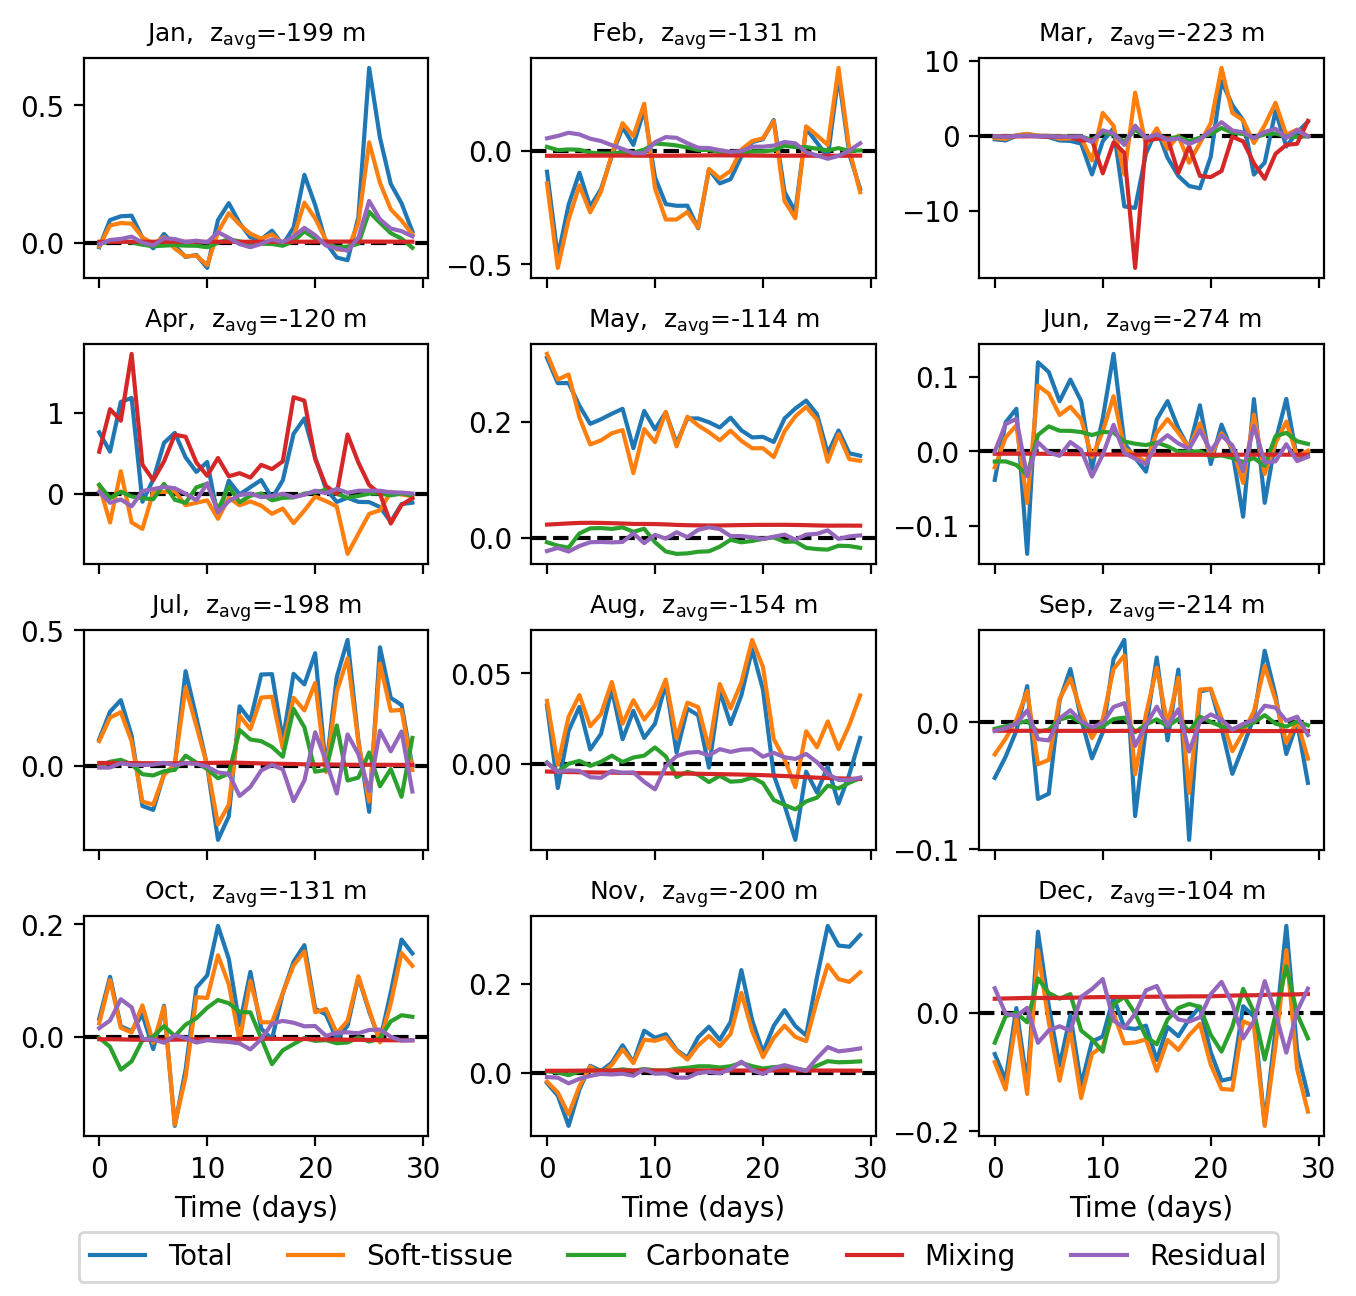

In [10]:
np.random.seed(69)

fig = plt.figure(figsize=(8, 7))
gs = fig.add_gridspec(4, 3, wspace=0.3, hspace=0.3)

first_day_of_month = [0, 31, 61, 92, 122, 153, 184, 214, 245, 275, 306, 337]
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

rantraj_2 = np.sort(np.random.choice(np.arange(0, ds.dims['trajectory']), 12, replace=False))

for i, traj in enumerate(rantraj_2):
    ax = fig.add_subplot(gs[i])

    startobs = ((3*30+1) + first_day_of_month[i] ) % 365
    ds_sub = ds.isel(obs=slice(startobs, startobs+30), trajectory=traj)

    ax.plot(np.arange(0, 30), ds_sub['DDIC'], label="Total")
    ax.plot(np.arange(0, 30), ds_sub['DDIC_bio_soft'], label="Soft-tissue")
    ax.plot(np.arange(0, 30), ds_sub['DDIC_bio_carbonate'], label="Carbonate")
    ax.plot(np.arange(0, 30), ds_sub['DDIC_diff'], label="Mixing")
    ax.plot(np.arange(0, 30), ds_sub['DDIC_residual'], label="Residual")
    
    # ax.set_title(f"Traj. {traj} — avg depth = {ds_sub.z.mean().values:.0f} m", color=colors[i], fontsize=10)
    # divide the values on the x-axis by 2
    
    if i < 9:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Time (days)")
    ax.axhline(0, color="k", linestyle="--", zorder=0)

    ax.set_title(f"{months[i]},  "+r"z$_\text{avg}$="+ f"-{ds_sub.z.mean().values:.0f} m", fontsize=9)
    

fig.legend(*ax.get_legend_handles_labels(), loc="lower center", ncol=5)
plt.tight_layout(rect=[0, 0.03, 1, 0.97]) 
plt.savefig("figures/example_fluxes_monthly.pdf", dpi=300)

In [11]:
def plot_stoichiometry_total(ds, obsslice=slice(None, 30)):
    # Plot the fluxes of nitrate and phosphate
    ds = ds.isel(obs=obsslice)
    y_min = np.min([ds['DNO3'][rantraj].min(), (16*ds['DPO4'][rantraj]).min()])
    y_max = np.max([ds['DNO3'][rantraj].max(), (16*ds['DPO4'][rantraj]).max()])

    fig, axs = plt.subplots(3, 3, figsize=(8, 8))
    for i, traj in enumerate(rantraj[:9]):
        ax = axs.flatten()[i]
        ax.plot(np.arange(0, ds['DDIC'].shape[1] * odt_days, odt_days), ds['DNO3'][traj], label="NO3")
        ax.plot(np.arange(0, ds['DDIC'].shape[1] * odt_days, odt_days), ds['DPO4'][traj], label="PO4")
        ax.plot(np.arange(0, ds['DDIC'].shape[1] * odt_days, odt_days), ds['DPO4'][traj] * 16, linestyle='--', label="NO3 from stoichiometry")
        ax.set_title(f"Traj {traj} — avg depth = {ds.z[traj].mean().values:.0f} m", color=colors[i], fontsize=10)
        ax.set_xlabel("Time (days)")
        if i%3 == 0:
            ax.set_ylabel(r"Flux (mmol m$^{-3}$ / $\Delta$ t")

        ax.set_ylim(y_min, y_max)
        ax.axhline(0, color="k", linestyle="--", zorder=0)

    fig.legend(*ax.get_legend_handles_labels(), loc="lower center", ncol=3)

    fig.suptitle("Nitrate and phosphate fluxes (total)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) 

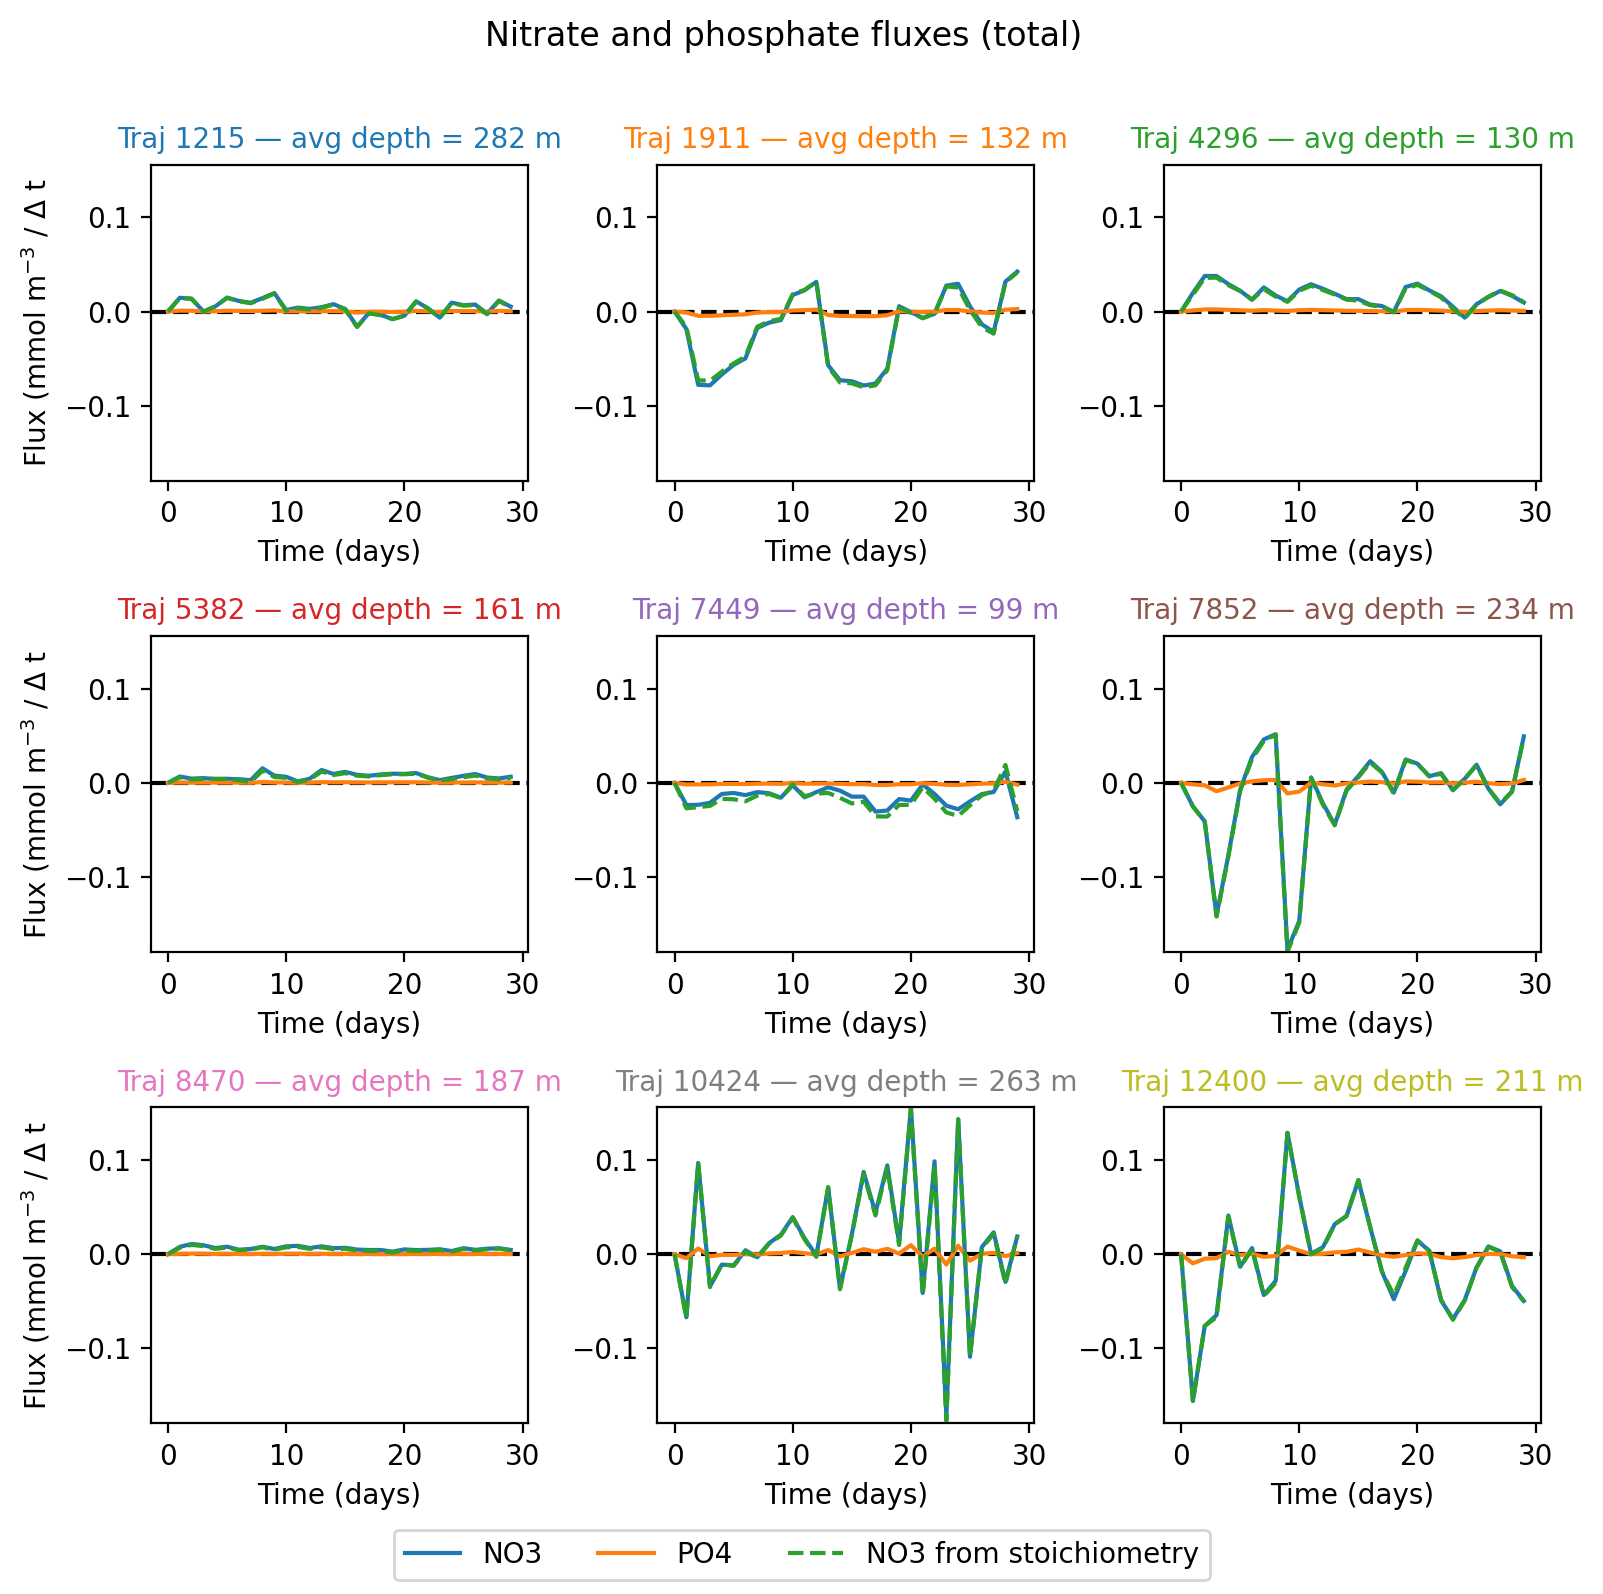

In [12]:
plot_stoichiometry_total(ds)

In [13]:
def plot_stoichiometry_bio(ds, obsslice=slice(None, 30)):
    # Plot the biogeochemical fluxes of nitrate and phosphate
    ds = ds.isel(obs=obsslice)
    
    y_min = np.min([ds['DNO3_bio'][rantraj].min(), (16*ds['DPO4_bio'][rantraj]).min()])
    y_max = np.max([ds['DNO3_bio'][rantraj].max(), (16*ds['DPO4_bio'][rantraj]).max()])

    fig, axs = plt.subplots(3, 3, figsize=(8, 8))
    for i, traj in enumerate(rantraj[:9]):
        ax = axs.flatten()[i]
        ax.plot(np.arange(0, ds['DDIC'].shape[1] * odt_days, odt_days), ds['DNO3_bio'][traj], label="DNO3")
        ax.plot(np.arange(0, ds['DDIC'].shape[1] * odt_days, odt_days), ds['DPO4_bio'][traj], label="DPO4")
        ax.plot(np.arange(0, ds['DDIC'].shape[1] * odt_days, odt_days), ds['DPO4_bio'][traj] * 16, linestyle='--', label="DNO3 from stoichiometry")
        ax.set_title(f"Traj {traj} — avg depth = {ds.z[traj].mean().values:.0f} m", color=colors[i], fontsize=10)
        ax.set_ylim(y_min, y_max)
        ax.set_xlabel("Time (days)")
        if i%3 == 0:
            ax.set_ylabel("Flux (mmol m$^{-3}$ / $\Delta$ t")
        ax.axhline(0, color="k", linestyle="--", zorder=0)

    fig.legend(*ax.get_legend_handles_labels(), loc="lower center", ncol=3)
    fig.suptitle("Nitrate and phosphate fluxes (biogeochemistry-attributed)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) 



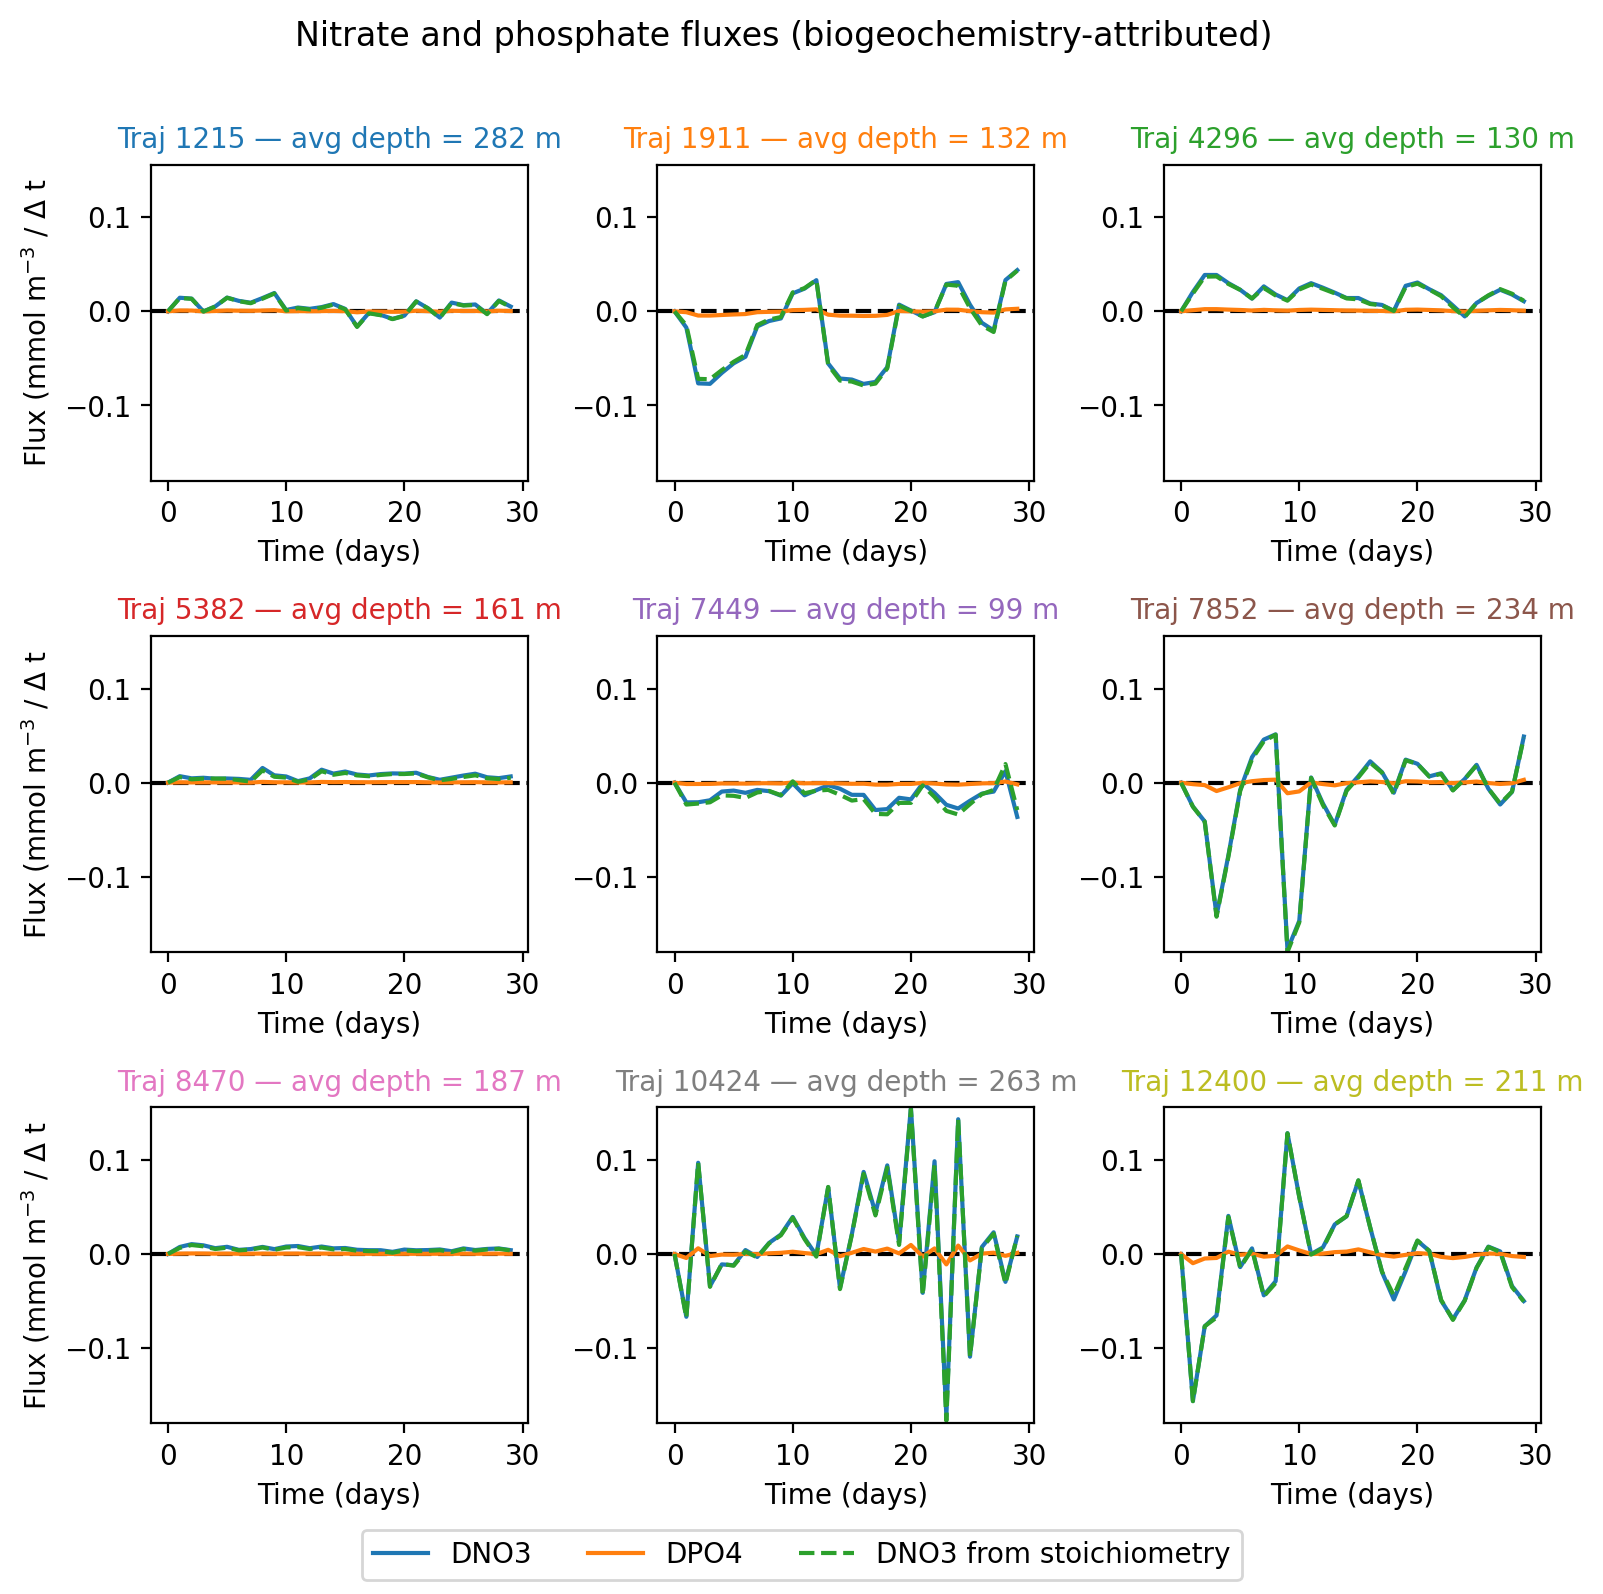

In [14]:
plot_stoichiometry_bio(ds)

# Investigating DIC flux Contributions

In [15]:
for year in tqdm(yeardict.keys()):
    yeardict[year]["masks"] = {}
    # slicing in order to match up the `obs` dimension with the fluxes
    yeardict[year]["masks"]["below_mixing"] = yeardict[year]['ds'].z.isel(obs=slice(1, None)) > yeardict[year]['ds'].MLDturb.isel(obs=slice(1, None))
    yeardict[year]["masks"]["below_mixed"] = yeardict[year]['ds'].z.isel(obs=slice(1, None)) > yeardict[year]['ds'].MLDtemp.isel(obs=slice(1, None))
    yeardict[year]["masks"]["below_200"] = yeardict[year]['ds'].z.isel(obs=slice(1, None)) > 200

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:15<00:00,  1.38it/s]


In [16]:
for year in tqdm(yeardict.keys()):
    yeardict[year]["flux_strengts"] = {}

    yeardict[year]["flux_strengts"]["abs_flux_strength_residual"]  = np.abs(yeardict[year]['ds']['DDIC_residual']).isel(obs=slice(1, None))
    yeardict[year]["flux_strengts"]["abs_flux_strength_bio"] = np.abs(yeardict[year]['ds']['DDIC_bio']).isel(obs=slice(1, None))
    yeardict[year]["flux_strengts"]["abs_flux_strength_bio_soft"] = np.abs(yeardict[year]['ds']['DDIC_bio_soft']).isel(obs=slice(1, None))
    yeardict[year]["flux_strengts"]["abs_flux_strength_bio_carbonate"] = np.abs(yeardict[year]['ds']['DDIC_bio_carbonate']).isel(obs=slice(1, None))
    yeardict[year]["flux_strengts"]["abs_flux_strength_Mixing"] = np.abs(yeardict[year]['ds']['DDIC_diff']).isel(obs=slice(1, None))

    yeardict[year]["flux_strengts"]["total_abs_strength"] = yeardict[year]["flux_strengts"]["abs_flux_strength_residual"] + yeardict[year]["flux_strengts"]["abs_flux_strength_bio_soft"] + yeardict[year]["flux_strengts"]["abs_flux_strength_bio_carbonate"] + yeardict[year]["flux_strengts"]["abs_flux_strength_Mixing"]


100%|██████████| 21/21 [00:15<00:00,  1.37it/s]


# Investigating Relative Contributions to ΔDIC

In [89]:
def cumsum_maximum_accounts_for(da, percentage):
    """
    Computes minimum value, for which if the array is filtered to contain
    only values larger than this value, the cumulative sum of the array
    accounts for at least the given percentage of the total sum of the array.
    This usually gives a higher value than the percentile, because the
    higher values in the array contribute more to the cumulative sum.

    Parameters
    ----------
    da : xarray.DataArray or np.array
        Input array
    percentage : float
        Percentage of the total sum of the array that should be accounted for.
        Should be between 0 and 1.
    """
    assert percentage >= 0 and percentage <= 1, "Percentage must be between 0 and 1"
    if type(da) == xr.DataArray:
        da = da.values
    da = da.astype(np.float64)
    arr = da.flatten()
    arr = arr[~np.isnan(arr)]
    arr_sorted = np.sort(arr)[::-1]
    cumsum = np.cumsum(arr_sorted)
    cumdist = cumsum / np.sum(arr_sorted)
    index = np.argmax(cumdist >= percentage)
    minval = arr_sorted[index]

    return minval

In [100]:
for year in tqdm(yeardict.keys()):
    yeardict[year]["flux_strengts"]["minval_95"] = {}
    yeardict[year]["flux_strengts"]["minval_95"]['all'] = cumsum_maximum_accounts_for(yeardict[year]['flux_strengts']['total_abs_strength'], 0.95)
    yeardict[year]["flux_strengts"]["minval_95"]['below_mixed'] = cumsum_maximum_accounts_for(yeardict[year]['flux_strengts']['total_abs_strength'].where(yeardict[year]["masks"]["below_mixed"]), 0.95)
    yeardict[year]["flux_strengts"]["minval_95"]['below_mixing'] = cumsum_maximum_accounts_for(yeardict[year]['flux_strengts']['total_abs_strength'].where(yeardict[year]["masks"]["below_mixing"]), 0.95)
    yeardict[year]["flux_strengts"]["minval_95"]['in_mixed'] = cumsum_maximum_accounts_for(yeardict[year]['flux_strengts']['total_abs_strength'].where(~yeardict[year]["masks"]["below_mixed"]), 0.95)
    yeardict[year]["flux_strengts"]["minval_95"]['in_mixing'] = cumsum_maximum_accounts_for(yeardict[year]['flux_strengts']['total_abs_strength'].where(~yeardict[year]["masks"]["below_mixed"]), 0.95)


100%|██████████| 21/21 [01:11<00:00,  3.41s/it]


In [101]:
for year in tqdm(yeardict.keys()):
    yeardict[year]["flux_strengts"]["percentile_mask"] = {}
    yeardict[year]["flux_strengts"]["percentile_mask"]['all'] = yeardict[year]["flux_strengts"]["minval_95"]['all'] * yeardict[year]["flux_strengts"]["total_abs_strength"]
    yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixed'] = yeardict[year]["flux_strengts"]["minval_95"]['below_mixed'] * yeardict[year]["flux_strengts"]["total_abs_strength"]
    yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixing'] = yeardict[year]["flux_strengts"]["minval_95"]['below_mixing'] * yeardict[year]["flux_strengts"]["total_abs_strength"]
    yeardict[year]["flux_strengts"]["percentile_mask"]['in_mixed'] = yeardict[year]["flux_strengts"]["minval_95"]['in_mixed'] * yeardict[year]["flux_strengts"]["total_abs_strength"]
    yeardict[year]["flux_strengts"]["percentile_mask"]['in_mixing'] = yeardict[year]["flux_strengts"]["minval_95"]['in_mixing'] * yeardict[year]["flux_strengts"]["total_abs_strength"]


100%|██████████| 21/21 [00:01<00:00, 20.48it/s]


In [102]:
for year in tqdm(yeardict.keys()):
    yeardict[year]["flux_strengts"]["relabs"] = {}
    yeardict[year]["flux_strengts"]["relabs"]['all'] = {
        "Biogeochemical": ((yeardict[year]["flux_strengts"]["abs_flux_strength_bio"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(yeardict[year]["flux_strengts"]["percentile_mask"]['all']).values,
        "Soft-tissue": ((yeardict[year]["flux_strengts"]["abs_flux_strength_bio_soft"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(yeardict[year]["flux_strengts"]["percentile_mask"]['all']).values,
        "Carbonate": ((yeardict[year]["flux_strengts"]["abs_flux_strength_bio_carbonate"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(yeardict[year]["flux_strengts"]["percentile_mask"]['all']).values,
        "Mixing": ((yeardict[year]["flux_strengts"]["abs_flux_strength_Mixing"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(yeardict[year]["flux_strengts"]["percentile_mask"]['all']).values,
        "Residual": ((yeardict[year]["flux_strengts"]["abs_flux_strength_residual"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(yeardict[year]["flux_strengts"]["percentile_mask"]['all']).values
    }

    yeardict[year]["flux_strengts"]["relabs"]['below_mixed'] = {
        "Biogeochemical": ((yeardict[year]["flux_strengts"]["abs_flux_strength_bio"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(yeardict[year]["masks"]["below_mixed"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixed']).values,
        "Soft-tissue": ((yeardict[year]["flux_strengts"]["abs_flux_strength_bio_soft"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(yeardict[year]["masks"]["below_mixed"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixed']).values,
        "Carbonate": ((yeardict[year]["flux_strengts"]["abs_flux_strength_bio_carbonate"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(yeardict[year]["masks"]["below_mixed"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixed']).values,
        "Mixing": ((yeardict[year]["flux_strengts"]["abs_flux_strength_Mixing"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(yeardict[year]["masks"]["below_mixed"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixed']).values,
        "Residual": ((yeardict[year]["flux_strengts"]["abs_flux_strength_residual"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(yeardict[year]["masks"]["below_mixed"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixed']).values
    }

    yeardict[year]["flux_strengts"]["relabs"]['below_mixing'] = {
        "Biogeochemical": ((yeardict[year]["flux_strengts"]["abs_flux_strength_bio"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(yeardict[year]["masks"]["below_mixing"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixing']).values,
        "Soft-tissue": ((yeardict[year]["flux_strengts"]["abs_flux_strength_bio_soft"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(yeardict[year]["masks"]["below_mixing"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixing']).values,
        "Carbonate": ((yeardict[year]["flux_strengts"]["abs_flux_strength_bio_carbonate"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(yeardict[year]["masks"]["below_mixing"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixing']).values,
        "Mixing": ((yeardict[year]["flux_strengts"]["abs_flux_strength_Mixing"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(yeardict[year]["masks"]["below_mixing"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixing']).values,
        "Residual": ((yeardict[year]["flux_strengts"]["abs_flux_strength_residual"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(yeardict[year]["masks"]["below_mixing"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixing']).values
    }

    yeardict[year]["flux_strengts"]["relabs"]['in_mixed'] = {
        "Biogeochemical": ((yeardict[year]["flux_strengts"]["abs_flux_strength_bio"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(~yeardict[year]["masks"]["below_mixed"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixing']).values,
        "Soft-tissue": ((yeardict[year]["flux_strengts"]["abs_flux_strength_bio_soft"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(~yeardict[year]["masks"]["below_mixed"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixing']).values,
        "Carbonate": ((yeardict[year]["flux_strengts"]["abs_flux_strength_bio_carbonate"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(~yeardict[year]["masks"]["below_mixed"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixing']).values,
        "Mixing": ((yeardict[year]["flux_strengts"]["abs_flux_strength_Mixing"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(~yeardict[year]["masks"]["below_mixed"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixing']).values,
        "Residual": ((yeardict[year]["flux_strengts"]["abs_flux_strength_residual"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(~yeardict[year]["masks"]["below_mixed"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixing']).values
    }

    yeardict[year]["flux_strengts"]["relabs"]['in_mixing'] = {
        "Biogeochemical": ((yeardict[year]["flux_strengts"]["abs_flux_strength_bio"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(~yeardict[year]["masks"]["below_mixed"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixing']).values,
        "Soft-tissue": ((yeardict[year]["flux_strengts"]["abs_flux_strength_bio_soft"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(~yeardict[year]["masks"]["below_mixed"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixing']).values,
        "Carbonate": ((yeardict[year]["flux_strengts"]["abs_flux_strength_bio_carbonate"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(~yeardict[year]["masks"]["below_mixed"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixing']).values,
        "Mixing": ((yeardict[year]["flux_strengts"]["abs_flux_strength_Mixing"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(~yeardict[year]["masks"]["below_mixed"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixing']).values,
        "Residual": ((yeardict[year]["flux_strengts"]["abs_flux_strength_residual"] / yeardict[year]["flux_strengts"]["total_abs_strength"]) * 100).where(~yeardict[year]["masks"]["below_mixed"] * yeardict[year]["flux_strengts"]["percentile_mask"]['below_mixing']).values
    }

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


In [103]:
for year in tqdm(yeardict.keys()):
    yeardict[year]['relabs_df'] =  pd.DataFrame(columns=["Biogeochemical", "Soft-tissue", "Carbonate", "Mixing", "Residual"])
    for pretty_name, name in zip(["All", "Below mixed layer", "Below mixing layer", "In mixed layer", "In mixing layer"], ["all", "below_mixed", "below_mixing", "in_mixed", "in_mixing"]):
        yeardict[year]['relabs_df'].loc[pretty_name] = pd.Series({
            process : np.nanmean(yeardict[year]["flux_strengts"]["relabs"][name][process]) for process in yeardict[year]["flux_strengts"]["relabs"][name].keys()
        })

100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


In [46]:
all_abs_flux_bio = np.concatenate([yeardict[year]['flux_strengts']['abs_flux_strength_bio'].values.flatten() for year in range(1995, 2016)])
all_abs_flux_bio_soft = np.concatenate([yeardict[year]['flux_strengts']['abs_flux_strength_bio_soft'].values.flatten() for year in range(1995, 2016)])
all_abs_flux_bio_carbonate = np.concatenate([yeardict[year]['flux_strengts']['abs_flux_strength_bio_carbonate'].values.flatten() for year in range(1995, 2016)])
all_abs_flux_residual = np.concatenate([yeardict[year]['flux_strengts']['abs_flux_strength_residual'].values.flatten() for year in range(1995, 2016)])
all_abs_flux_mixing = np.concatenate([yeardict[year]['flux_strengts']['abs_flux_strength_Mixing'].values.flatten() for year in range(1995, 2016)])
all_abs_flux_total = np.concatenate([yeardict[year]['flux_strengts']['total_abs_strength'].values.flatten() for year in range(1995, 2016)])

In [52]:
assert np.allclose(all_abs_flux_bio_soft + all_abs_flux_bio_carbonate + all_abs_flux_residual + all_abs_flux_mixing, all_abs_flux_total)

In [53]:
all_mask_below_mixed = np.concatenate([yeardict[year]["masks"]["below_mixed"].values.flatten() for year in range(1995, 2016)])
all_mask_below_mixing = np.concatenate([yeardict[year]["masks"]["below_mixing"].values.flatten() for year in range(1995, 2016)])
all_mask_in_mixing = np.concatenate([~yeardict[year]["masks"]["below_mixing"].values.flatten() for year in range(1995, 2016)])
all_mask_in_mixed = np.concatenate([~yeardict[year]["masks"]["below_mixed"].values.flatten() for year in range(1995, 2016)])

In [126]:
cumsum_top95 = cumsum_maximum_accounts_for(all_abs_flux_total, 0.95)
cumsum_top_95_mask = all_abs_flux_total > cumsum_top95
print(f"{cumsum_top_95_mask.sum() / cumsum_top_95_mask.size * 100=}")
print(f"{cumsum_top95=}")

cumsum_top_95_mask.sum() / cumsum_top_95_mask.size * 100=68.03984530816729
cumsum_top95=0.05775259807705879


In [120]:
df_relabs_all = pd.DataFrame(columns=["Biogeochemical", "Soft-tissue", "Carbonate", "Mixing", "Residual"])
df_relabs_all.loc["All"] = pd.Series({
    "Biogeochemical" : (all_abs_flux_bio/all_abs_flux_total)[cumsum_top_95_mask].mean() * 100,
    "Soft-tissue" : (all_abs_flux_bio_soft/all_abs_flux_total)[cumsum_top_95_mask].mean() * 100,
    "Carbonate" : (all_abs_flux_bio_carbonate/all_abs_flux_total)[cumsum_top_95_mask].mean() * 100,
    "Mixing" : (all_abs_flux_mixing/all_abs_flux_total)[cumsum_top_95_mask].mean() * 100,
    "Residual" : (all_abs_flux_residual/all_abs_flux_total)[cumsum_top_95_mask].mean() * 100
})
df_relabs_all.loc["Below mixed layer"] = pd.Series({
    "Biogeochemical" : (all_abs_flux_bio/all_abs_flux_total)[cumsum_top_95_mask & all_mask_below_mixed].mean() * 100,
    "Soft-tissue" : (all_abs_flux_bio_soft/all_abs_flux_total)[cumsum_top_95_mask & all_mask_below_mixed].mean() * 100,
    "Carbonate" : (all_abs_flux_bio_carbonate/all_abs_flux_total)[cumsum_top_95_mask & all_mask_below_mixed].mean() * 100,
    "Mixing" : (all_abs_flux_mixing/all_abs_flux_total)[cumsum_top_95_mask & all_mask_below_mixed].mean() * 100,
    "Residual" : (all_abs_flux_residual/all_abs_flux_total)[cumsum_top_95_mask & all_mask_below_mixed].mean() * 100
})
df_relabs_all.loc["Below mixing layer"] = pd.Series({
    "Biogeochemical" : (all_abs_flux_bio/all_abs_flux_total)[cumsum_top_95_mask & all_mask_below_mixing].mean() * 100,
    "Soft-tissue" : (all_abs_flux_bio_soft/all_abs_flux_total)[cumsum_top_95_mask & all_mask_below_mixing].mean() * 100,
    "Carbonate" : (all_abs_flux_bio_carbonate/all_abs_flux_total)[cumsum_top_95_mask & all_mask_below_mixing].mean() * 100,
    "Mixing" : (all_abs_flux_mixing/all_abs_flux_total)[cumsum_top_95_mask & all_mask_below_mixing].mean() * 100,
    "Residual" : (all_abs_flux_residual/all_abs_flux_total)[cumsum_top_95_mask & all_mask_below_mixing].mean() * 100
})
df_relabs_all.loc["In mixed layer"] = pd.Series({
    "Biogeochemical" : (all_abs_flux_bio/all_abs_flux_total)[cumsum_top_95_mask & all_mask_in_mixed].mean() * 100,
    "Soft-tissue" : (all_abs_flux_bio_soft/all_abs_flux_total)[cumsum_top_95_mask & all_mask_in_mixed].mean() * 100,
    "Carbonate" : (all_abs_flux_bio_carbonate/all_abs_flux_total)[cumsum_top_95_mask & all_mask_in_mixed].mean() * 100,
    "Mixing" : (all_abs_flux_mixing/all_abs_flux_total)[cumsum_top_95_mask & all_mask_in_mixed].mean() * 100,
    "Residual" : (all_abs_flux_residual/all_abs_flux_total)[cumsum_top_95_mask & all_mask_in_mixed].mean() * 100
})
df_relabs_all.loc["In mixing layer"] = pd.Series({
    "Biogeochemical" : (all_abs_flux_bio/all_abs_flux_total)[cumsum_top_95_mask & all_mask_in_mixing].mean() * 100,
    "Soft-tissue" : (all_abs_flux_bio_soft/all_abs_flux_total)[cumsum_top_95_mask & all_mask_in_mixing].mean() * 100,
    "Carbonate" : (all_abs_flux_bio_carbonate/all_abs_flux_total)[cumsum_top_95_mask & all_mask_in_mixing].mean() * 100,
    "Mixing" : (all_abs_flux_mixing/all_abs_flux_total)[cumsum_top_95_mask & all_mask_in_mixing].mean() * 100,
    "Residual" : (all_abs_flux_residual/all_abs_flux_total)[cumsum_top_95_mask & all_mask_in_mixing].mean() * 100
})


In [121]:
df_relabs_all

,Biogeochemical,Soft-tissue,Carbonate,Mixing,Residual
All,70.079434,63.344407,12.981407,4.904170,18.770035
Below mixed layer,70.806080,64.013070,13.239095,3.520775,19.227038
Below mixing layer,70.651048,63.864577,13.112697,4.040105,18.982506
In mixed layer,57.548326,51.815730,8.538014,28.755185,10.891072
In mixing layer,39.089516,35.137624,5.864032,51.747578,7.250789


In [63]:
df_mean_rel_abs = copy.deepcopy(yeardict[1995]['relabs_df'])
for i in range(1996, 2016):
    df_mean_rel_abs += yeardict[i]['relabs_df']
df_mean_rel_abs /= 21
df_mean_rel_abs

,Biogeochemical,Soft-tissue,Carbonate,Mixing,Residual
All,66.866844,59.828255,14.067143,5.895403,20.209187
Below mixed layer,67.278870,60.185238,14.269261,4.992147,20.553356
Below mixing layer,67.221329,60.143745,14.164414,5.332656,20.359186
In mixed layer,58.776413,52.485153,9.462517,26.354525,11.697807
In mixing layer,58.776413,52.485153,9.462517,26.354525,11.697807


# Compute correlation between the errors

In [67]:
def plot_correlation_matrix(df, add_title=None):
    # define a function to get the p-value and asterisks for each correlation coefficient
    def get_pvalue_asterisks(x, y):
        r, p = stats.pearsonr(x, y)
        if p < 0.05:
            return f"{r:.2f}*", p
        else:
            return f"{r:.2f}", p

    n_var = len(df.columns)

    # compute the correlation matrix and the p-values
    corr, p_values = np.zeros((n_var, n_var)), np.zeros((n_var, n_var))
    for i, col1 in enumerate(df.columns):
        for j, col2 in enumerate(df.columns):
            corr[i, j], p_values[i, j] = stats.pearsonr(df[col1], df[col2])

    # create the heatmap with asterisks for significant correlations
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(corr, annot=False, fmt="", cmap="RdBu", ax=ax, vmin=-1, vmax=1, cbar_kws={"label": "Correlation coefficient"})

    min_corr, max_corr = corr.min(), corr.max()
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            asterisks, p = get_pvalue_asterisks(df.iloc[:, i], df.iloc[:, j])
            color = "black" if np.abs(corr[i,j]) < 0.5 else "white"
            ax.text(j+0.5, i+0.5, asterisks, ha="center", va="center", color=color)

    plt.xticks(np.arange(0.5, n_var+.5), df.columns, rotation=45)
    plt.yticks(np.arange(0.5, n_var+.5), df.columns, rotation=0)
    title = "Correlation matrix (* = p < 0.05)"
    if add_title:
        title = add_title + ", " + title
    plt.title(title)
    plt.show()

In [65]:
df_full_all = pd.DataFrame({
    "Total": np.concatenate([yeardict[year]['ds'].DDIC[:, 1:].values.flatten() for year in range(1995, 2016)]),
    "Biogeochemical": np.concatenate([yeardict[year]['ds'].DDIC_bio[:, 1:].values.flatten() for year in range(1995, 2016)]),
    "Soft-tissue": np.concatenate([yeardict[year]['ds'].DDIC_bio_soft[:, 1:].values.flatten() for year in range(1995, 2016)]),
    "Carbonate": np.concatenate([yeardict[year]['ds'].DDIC_bio_carbonate[:, 1:].values.flatten() for year in range(1995, 2016)]),
    "Mixing": np.concatenate([yeardict[year]['ds'].DDIC_diff[:, 1:].values.flatten() for year in range(1995, 2016)]),
    "Residual": np.concatenate([yeardict[year]['ds'].DDIC_residual[:, 1:].values.flatten() for year in range(1995, 2016)])
})

In [69]:
df_full_all.corr()

,Total,Biogeochemical,Soft-tissue,Carbonate,Mixing,Residual
Total,1.000000,0.613008,0.604607,0.422513,0.520356,0.237298
Biogeochemical,0.613008,1.000000,0.988339,0.679392,-0.331251,0.101094
Soft-tissue,0.604607,0.988339,1.000000,0.559737,-0.330527,0.106741
Carbonate,0.422513,0.679392,0.559737,1.000000,-0.209923,0.035788
Mixing,0.520356,-0.331251,-0.330527,-0.209923,1.000000,-0.051237
Residual,0.237298,0.101094,0.106741,0.035788,-0.051237,1.000000


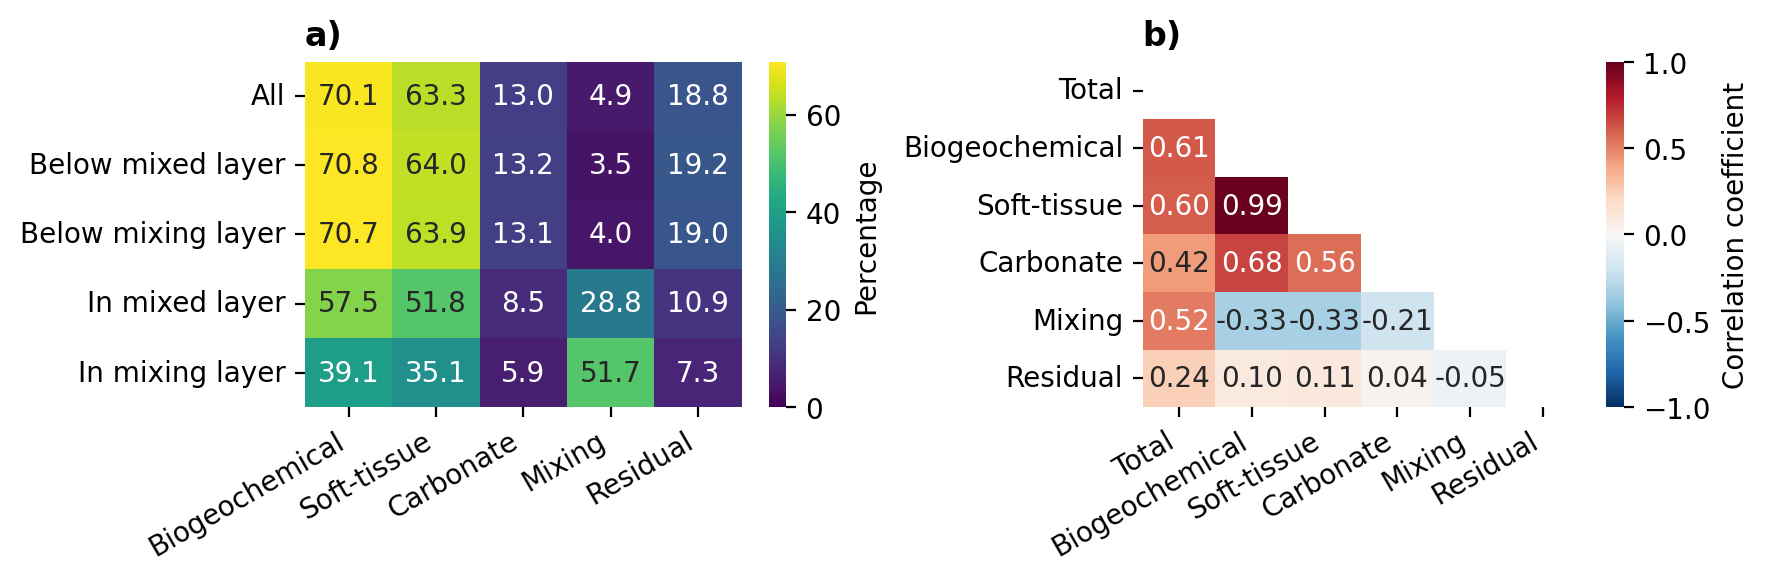

In [124]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 3))

sns.heatmap(df_relabs_all, ax=axes[0], annot=True, cmap="viridis", fmt=".1f", cbar_kws={"label": "Percentage"}, vmin=0)
axes[0].set_title("a)", loc="left", fontweight="bold")
axes[0].set_xticks(np.arange(0.5, 5+.5), df_relabs_all.columns, rotation=30, ha='right')

n_var = len(df_full.columns)

corr = df_full_all.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, ax=axes[1], mask=mask, annot=True, fmt=".2f", cmap="RdBu_r", vmin=-1, vmax=1, cbar_kws={"label": "Correlation coefficient"})

axes[1].set_title("b)", loc="left", fontweight="bold")
axes[1].set_xticks(np.arange(0.5, n_var+.5), df_full.columns, rotation=30, ha='right')
axes[1].set_yticks(np.arange(0.5, n_var+.5), df_full.columns, rotation=0)

fig.tight_layout()
plt.savefig("figures/flux_significance_and_correlation.pdf", dpi=300)